In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
import matplotlib.pyplot as plt


PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [0]:
import gensim

In [3]:


!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

!unzip -uq snli_1.0.zip


--2020-05-15 10:30:49--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  20.7MB/s    in 7.5s    

2020-05-15 10:30:57 (12.1 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]



In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:


from collections import Counter

# max_vocab_size = 25000
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    token_counter = Counter(all_tokens)
#     print(token_counter)
    vocab = token_counter.keys()
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def read_data(fine_name):
    df = pd.read_csv(fine_name,sep='\t')
    return df



In [0]:
train_datapath = "./snli_1.0/snli_1.0_train.jsonl"
valid_datapath = "./snli_1.0/snli_1.0_dev.jsonl"
test_datapath = "./snli_1.0/snli_1.0_test.jsonl"

df_train = pd.read_json(train_datapath, lines = "true")
df_val = pd.read_json(valid_datapath, lines = "true")
df_test = pd.read_json(test_datapath, lines = "true")



In [0]:



def tokenize(df):
    df['sentence1'] = df['sentence1'].apply(lambda x: [a.lower() for a in x.split(' ')])
    df['sentence2'] = df['sentence2'].apply(lambda x : [a.lower() for a in x.split(' ')])
    
    return df





In [0]:
df_train = tokenize(df_train)
df_val = tokenize(df_val)

In [9]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip -uq wiki-news-300d-1M.vec.zip

--2020-05-15 10:31:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  11.8MB/s    in 57s     

2020-05-15 10:32:56 (11.5 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [0]:
words_to_load = 100000

import numpy as np

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = ['<pad>','<unk>']
    i = 2
    for line in f:
        if i-2 >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        idx2words[i] = s[0]
        ordered_words.append(s[0])
        i = i+1


In [11]:
# max(words.values())

100001

In [0]:
words['<pad>'] = 0
words['<unk>'] = 1

In [0]:
idx2words[0] = "<pad>"
idx2words[1] = "<unk>"

In [0]:
# words
def apply_idz(x):
    temp = []
    for a in x:
        if a in ordered_words:
            temp.append(words[a])
        else:
            temp.append(1)
    return temp

In [0]:
def idize(df):
    df['sentence1_idz'] = df["sentence1"].apply(apply_idz)
    df['sentence2_idz'] = df["sentence2"].apply(apply_idz)
    return df
    

In [0]:
train_train = idize(df_train)

In [0]:

val_val = idize(df_val)

In [18]:
val_val.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse,sentence1_idz,sentence2_idz
0,"[neutral, entailment, neutral, neutral, neutral]",4705552913.jpg#2,neutral,4705552913.jpg#2r1n,"[two, women, are, embracing, while, holding, t...",( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,"[the, sisters, are, hugging, goodbye, while, h...",( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[4, 6555, 35, 28644, 20026, 132, 1671, 8, 324,..."
1,"[entailment, entailment, entailment, entailmen...",4705552913.jpg#2,entailment,4705552913.jpg#2r1e,"[two, women, are, embracing, while, holding, t...",( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,"[two, woman, are, holding, packages.]",( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[108, 995, 35, 1671, 1]"
2,"[contradiction, contradiction, contradiction, ...",4705552913.jpg#2,contradiction,4705552913.jpg#2r1c,"[two, women, are, embracing, while, holding, t...",( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,"[the, men, are, fighting, outside, a, deli.]",( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[4, 356, 35, 1613, 530, 10, 1]"
3,"[entailment, entailment, entailment, entailmen...",2407214681.jpg#0,entailment,2407214681.jpg#0r1e,"[two, young, children, in, blue, jerseys,, one...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,"[two, kids, in, numbered, jerseys, wash, their...",( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"[108, 803, 250, 9, 2032, 1, 47, 20, 4, 391, 52...","[108, 1316, 9, 8665, 26645, 10523, 48, 1]"
4,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"[two, young, children, in, blue, jerseys,, one...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,"[two, kids, at, a, ballgame, wash, their, hands.]",( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"[108, 803, 250, 9, 2032, 1, 47, 20, 4, 391, 52...","[108, 1316, 30, 10, 78076, 10523, 48, 1]"


In [0]:
unk_vec = np.random.normal(size=300)
pad_vec = np.random.normal(size=300)

In [20]:
# loaded_embeddings.shape

(100002, 300)

In [0]:


loaded_embeddings[0,:] = pad_vec
# np.insert(loaded_embeddings,0,pad_vec,axis=0)
loaded_embeddings[1,:] = unk_vec
# np.insert(loaded_embeddings,1,unk_vec,axis=0)



In [22]:
val_val=val_val[['sentence1','sentence2','gold_label','sentence1_idz','sentence2_idz']]
val_val=val_val.rename(columns={'gold_label':'label'})
# val_val.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[two, women, are, embracing, while, holding, t...","[the, sisters, are, hugging, goodbye, while, h...",neutral,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[4, 6555, 35, 28644, 20026, 132, 1671, 8, 324,..."
1,"[two, women, are, embracing, while, holding, t...","[two, woman, are, holding, packages.]",entailment,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[108, 995, 35, 1671, 1]"
2,"[two, women, are, embracing, while, holding, t...","[the, men, are, fighting, outside, a, deli.]",contradiction,"[108, 272, 35, 13154, 132, 1671, 8, 324, 1]","[4, 356, 35, 1613, 530, 10, 1]"
3,"[two, young, children, in, blue, jerseys,, one...","[two, kids, in, numbered, jerseys, wash, their...",entailment,"[108, 803, 250, 9, 2032, 1, 47, 20, 4, 391, 52...","[108, 1316, 9, 8665, 26645, 10523, 48, 1]"
4,"[two, young, children, in, blue, jerseys,, one...","[two, kids, at, a, ballgame, wash, their, hands.]",neutral,"[108, 803, 250, 9, 2032, 1, 47, 20, 4, 391, 52...","[108, 1316, 30, 10, 78076, 10523, 48, 1]"


In [0]:

train_train=train_train[['sentence1','sentence2','gold_label','sentence1_idz','sentence2_idz']]

In [24]:
train_train=train_train.rename(columns={'gold_label':'label'})

# train_train.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, training, his, horse, for, a, ...",neutral,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 590, 45, 2924, 17, 10, 1]"
1,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, at, a, diner,, ordering, an, o...",contradiction,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 30, 10, 1, 6859, 51, 1]"
2,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, outdoors,, on, a, horse.]",entailment,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 1, 18, 10, 1]"
3,"[children, smiling, and, waving, at, camera]","[they, are, smiling, at, their, parents]",neutral,"[250, 9767, 6, 13518, 30, 2421]","[73, 35, 9767, 30, 48, 859]"
4,"[children, smiling, and, waving, at, camera]","[there, are, children, present]",entailment,"[250, 9767, 6, 13518, 30, 2421]","[83, 35, 250, 371]"


In [0]:
def encode_target(train_train):
    train_train['label'][train_train['label']=='neutral']=0
    train_train['label'][train_train['label']=='entailment']=1
    train_train['label'][train_train['label']=='contradiction']=2
    return train_train

In [26]:


train_train = encode_target(train_train)
val_val = encode_target(val_val)
# train_train.head()


,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, training, his, horse, for, a, ...",0,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 590, 45, 2924, 17, 10, 1]"
1,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, at, a, diner,, ordering, an, o...",2,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 30, 10, 1, 6859, 51, 1]"
2,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, outdoors,, on, a, horse.]",1,"[10, 364, 18, 10, 2924, 13037, 95, 10, 2471, 2...","[10, 364, 16, 1, 18, 10, 1]"
3,"[children, smiling, and, waving, at, camera]","[they, are, smiling, at, their, parents]",0,"[250, 9767, 6, 13518, 30, 2421]","[73, 35, 9767, 30, 48, 859]"
4,"[children, smiling, and, waving, at, camera]","[there, are, children, present]",1,"[250, 9767, 6, 13518, 30, 2421]","[83, 35, 250, 371]"


In [27]:
print(train_train['label'][0])

0


In [0]:
for i in range(len(train_train)):
  if(train_train['label'][i]!=0 and train_train['label'][i]!=1 and train_train['label'][i]!=2):
    train_train['label'][i]=1
  

In [0]:
for i in range(len(val_val)):
  if(val_val['label'][i]!=0 and val_val['label'][i]!=1 and val_val['label'][i]!=2):
    val_val['label'][i]=1

In [0]:
class SnliDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s1 = self.df.iloc[idx]['sentence1_idz']
        s2 = self.df.iloc[idx]['sentence2_idz']
        tar = self.df.iloc[idx]['label']
        len1 = len(s1)
        len2 = len(s2)
        return [s1,len1,s2,len2,tar]

In [0]:
def max_len(x):
    return len(x)

In [0]:
l1 = train_train['sentence1_idz'].apply(max_len)
l2 = train_train['sentence2_idz'].apply(max_len)
# MAX_LEN = max(l1)
MAX_LEN = 25

In [0]:

def vocab_collate_func(batch):
    data_list_s1 = []
    data_list_s2 = []
    label_list = []
    length_list_s1 = []
    length_list_s2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[1])
        length_list_s2.append(datum[3])
    # padding
    for datum in batch:
        if datum[1]>MAX_LEN:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN - datum[1])),
                                mode="constant", constant_values=0)
        if datum[3]>MAX_LEN:
            padded_vec_s2 = np.array(datum[2])[:MAX_LEN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_LEN - datum[3])),
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
        
    # print(torch.from_numpy(np.array(data_list_s1)))
    # print(torch.LongTensor(length_list_s1))
    # print(torch.from_numpy(np.array(data_list_s2)))
    # print(torch.LongTensor(length_list_s2))
    # print(torch.LongTensor(label_list))
       
    return [torch.from_numpy(np.array(data_list_s1)), torch.LongTensor(length_list_s1), torch.from_numpy(np.array(data_list_s2)), torch.LongTensor(length_list_s2), torch.LongTensor(label_list)]

In [0]:
train_dataset = SnliDataset(train_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SnliDataset(val_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [0]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = True)


        
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first = True)
        self.linear1 = nn.Linear(2*hidden_size, 500)
        self.linear2 = nn.Linear(500,num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, data_s1, length1, data_s2, length2):  
        batch_size = data_s1.size(0)
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(data_s1)
        embed2 = self.embedding(data_s2)
        
#         print(embed1.size())
        rnn_out1_, hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2_, hidden2 = self.rnn(embed2, self.hidden2)
#         print(self.hidden1.size())

        rnn_out1 = torch.sum(hidden1, dim=0)
        rnn_out2 = torch.sum(hidden2, dim=0)
#         print(rnn_out1.size())
        combined_out = torch.cat([rnn_out1, rnn_out2], dim=1)
#         print(combined_out.size())
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(logits)
        
        return res

In [0]:
dataloaders = [train_loader, val_loader]

In [0]:
def training(model,criterion, optimizer, name, num_epochs):
    best_loss = np.inf
    best_acc = 0
    loss_hist = {'train':[],'validate':[]}
    acc_hist = {'train':[],'validate':[]}
    for i in range(num_epochs):
        for enu,phase in enumerate(['train', 'validate']):
            running_loss = 0
            running_total = 0
            correct = 0
            total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
            for (data1, length1, data2, length2, labels) in dataloaders[enu]:
#                 data_batch1, length_batch1, data_batch2, len_batch2, label_batch = data1, length1, data2, length2, labels
                data_batch1, len_batch1, data_batch2, len_batch2, label_batch = data1.cuda(), length1.cuda(), data2.cuda(), length2.cuda(), labels.cuda()


                optimizer.zero_grad()
                outputs = model(data_batch1, len_batch1, data_batch2, len_batch2)
                loss = criterion(outputs, label_batch)
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                N = labels.size(0)
                # print(type(loss))
                # print(type(N))
                outputs = F.softmax(outputs, dim=1)
                predicted = outputs.max(1, keepdim=True)[1]
#                 print(type(predicted))
                total += labels.size(0)
                correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
                running_loss += loss.item() * N  # changed
                running_total += N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss)
            accuracy = 100 * correct / total
            acc_hist[phase].append(accuracy)
            print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, accuracy: {:.4f}'\
                      .format(i,phase,epoch_loss, accuracy))
        if phase == 'validate' and best_acc < accuracy:
            best_loss = epoch_loss
            best_acc = accuracy
            torch.save(model,name)
    print('Best val dice loss: {:4f}, Best Accuracy: {:4f}'.format(best_loss,best_acc))
    return model, loss_hist, acc_hist

In [0]:
class RNN_dp(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,p_p):
        super(RNN_dp, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
#         self.embedding.weight.data.copy_(torch.from_numpy(loaded_embeddings))
#         self.embedding.weight.requires_grad = False
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = True)
        self.drop = nn.Dropout(p=p_p)


        
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first = True)
        self.linear1 = nn.Linear(2*hidden_size, 500)
        self.linear2 = nn.Linear(500,num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, data_s1, length1, data_s2, length2):  
        batch_size = data_s1.size(0)
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(data_s1)
        embed2 = self.embedding(data_s2)
        
#         print(embed1.size())
        rnn_out1_, hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2_, hidden2 = self.rnn(embed2, self.hidden2)
#         print(self.hidden1.size())

        rnn_out1 = torch.sum(hidden1, dim=0)
        rnn_out2 = torch.sum(hidden2, dim=0)
#         print(rnn_out1.size())
        combined_out = torch.cat([rnn_out1, rnn_out2], dim=1)
#         print(combined_out.size())
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(self.drop(logits))
        
        return res


In [40]:

model = RNN_dp(300,500,2,3,words_to_load+2,0.2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn16",10)

Epoch: 0, Phase: train, epoch loss: 0.8673, accuracy: 59.6333
Epoch: 0, Phase: validate, epoch loss: 0.7880, accuracy: 65.6600


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN_dp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7652, accuracy: 66.2953
Epoch: 1, Phase: validate, epoch loss: 0.7623, accuracy: 66.9000
Epoch: 2, Phase: train, epoch loss: 0.7305, accuracy: 68.2599
Epoch: 2, Phase: validate, epoch loss: 0.7451, accuracy: 67.6500
Epoch: 3, Phase: train, epoch loss: 0.7077, accuracy: 69.4054
Epoch: 3, Phase: validate, epoch loss: 0.7533, accuracy: 67.9100
Epoch: 4, Phase: train, epoch loss: 0.6909, accuracy: 70.2515
Epoch: 4, Phase: validate, epoch loss: 0.7478, accuracy: 67.8800
Epoch: 5, Phase: train, epoch loss: 0.6774, accuracy: 70.8915
Epoch: 5, Phase: validate, epoch loss: 0.7522, accuracy: 68.0200
Epoch: 6, Phase: train, epoch loss: 0.6682, accuracy: 71.3994
Epoch: 6, Phase: validate, epoch loss: 0.7531, accuracy: 68.0500
Epoch: 7, Phase: train, epoch loss: 0.6609, accuracy: 71.7785
Epoch: 7, Phase: validate, epoch loss: 0.7628, accuracy: 67.7800
Epoch: 8, Phase: train, epoch loss: 0.6557, accuracy: 72.0068
Epoch: 8, Phase: validate, epoch loss: 0.7531, ac

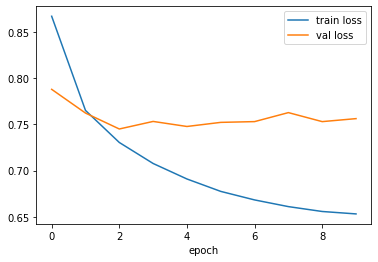

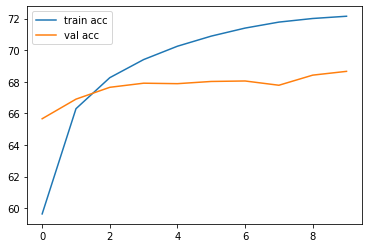

In [41]:
plt.plot(loss_hists['train'],label="train loss")
plt.xlabel("epoch")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

In [43]:
import pickle

f='modelrnn1.sav'
pickle.dump(model, open(f, 'wb'))



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [46]:
filename = '/content/gdrive/My Drive/finalized_modelrnn.sav'
pickle.dump(model, open(filename, 'wb'))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:

path = F"/content/gdrive/My Drive/final_modelrnn.pt" 
torch.save(model.state_dict(), path)

In [0]:
# path = F"/content/gdrive/My Drive/{model_save_name}"
# model.load_state_dict(torch.load(path))